In [3]:
import pandas as pd

def read_file(filename, temperature):
    with open(filename, 'r') as file:
        lines = file.readlines()[35:]  # Skip first 35 lines
    data = []

    for line in lines:
        elements = line.split('\t')  # Split line into elements by tabs
        if len(elements) >= 17:  # Check if there are at least 17 elements
            element_8 = elements[7]  # Get 8th element (0-indexed)
            element_10 = float(elements[9])/1000 # pressure
            element_12 = elements[11]  # gas_fraction
            element_17 = elements[16]  # liquid_fraction
            
            if element_8 != 'NaN':
                found_data = True
            if element_8 == 'NaN' and found_data:
                break           

            if element_8 != 'NaN':
                data.append([temperature, float(element_10), float(element_12), float(element_17)])
    # return data
    return pd.DataFrame(data, columns=['temperature', 'pressure', 'gas_fraction', 'liquid_fraction'])




In [27]:
import os
import re
import numpy as np
import pandas as pd
from collections import defaultdict
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error

def group_files_by_kij(directory):
    # Dictionary to hold lists of filenames grouped by kij
    grouped_files = defaultdict(list)
    
    # Regular expression to match filenames and extract kij
    pattern = re.compile(r'out_[^_]+_([^_]+)\.txt')
    
    # Iterate over all files in the specified directory
    for filename in os.listdir(directory):
        match = pattern.match(filename)
        if match:
            kij = match.group(1)
            grouped_files[kij].append(filename)
    
    return grouped_files

directory = 'julia_out/sc_data/'
grouped_files = group_files_by_kij(directory)


def get_mses(data_first, data_second, power=3):
    # Remove None values separately for gas_fraction and liquid_fraction
    data_first_gas = data_first.dropna(subset=['gas_fraction'])
    data_first_liquid = data_first.dropna(subset=['liquid_fraction'])
    
    data_second_gas = data_second.dropna(subset=['gas_fraction'])
    data_second_liquid = data_second.dropna(subset=['liquid_fraction'])
    
    # Function to fit polynomial and calculate MSE
    def fit_and_calculate_mse(data1, data2, column):
        if len(data1) < power + 1 or len(data2) < power + 1:
            return None
        poly1 = np.polyfit(data1['pressure'], data1[column], power)
        poly2 = np.polyfit(data2['pressure'], data2[column], power)
        poly1_func = np.poly1d(poly1)
        poly2_func = np.poly1d(poly2)
        pressure_common = np.linspace(min(data1['pressure'].min(), data2['pressure'].min()), 
                                      max(data1['pressure'].max(), data2['pressure'].max()), 100)
        values1 = poly1_func(pressure_common)
        values2 = poly2_func(pressure_common)
        return mean_squared_error(values1, values2)
    
    mse_gas = fit_and_calculate_mse(data_first_gas, data_second_gas, 'gas_fraction')
    mse_liquid = fit_and_calculate_mse(data_first_liquid, data_second_liquid, 'liquid_fraction')

    return mse_gas, mse_liquid



real_data = pd.read_csv('pressure_fraction_graph_data.csv')
mses = dict()
for file in list(grouped_files.items())[0][1]:
    temperature = float(file.split('_')[1])
    mses[temperature] = dict()
for kij, files in grouped_files.items():
    # mses[kij] = dict()
    for file in files:
        temperature = float(file.split('_')[1])
        file_data = read_file(directory + file, temperature)
        cut_real_data = real_data[real_data['temperature'] == temperature]
        # mses[kij][temperature] = get_mses(file_data, cut_real_data, 2)
        mses[temperature][float(kij)] = get_mses(file_data, cut_real_data, 2)
        # print(get_mses(file_data, cut_real_data, 3))
        # print(get_mses(file_data, cut_real_data, 4))
        # print(file_data)
        # break
    


<Figure size 1000x500 with 0 Axes>

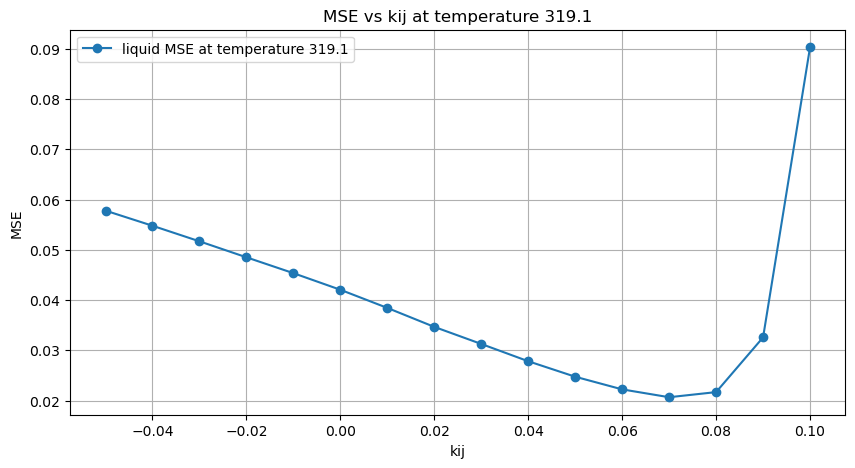

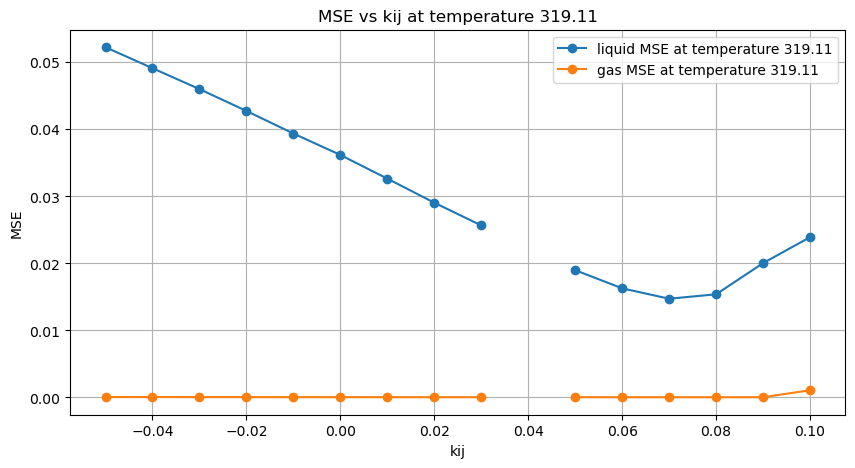

<Figure size 1000x500 with 0 Axes>

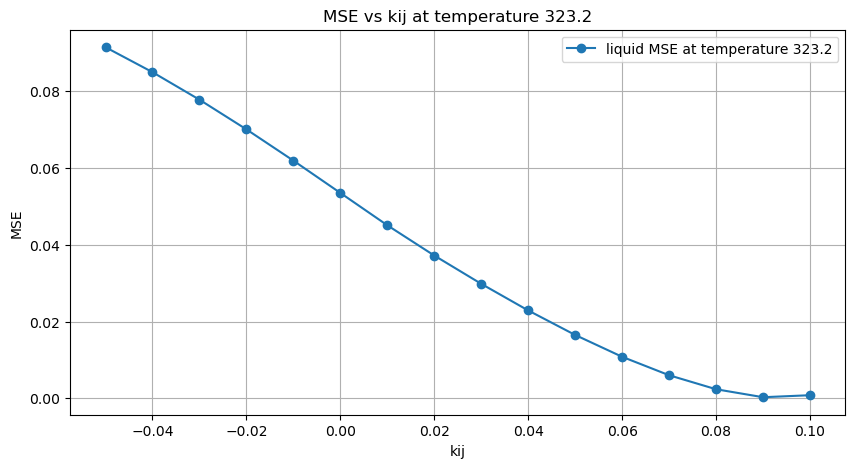

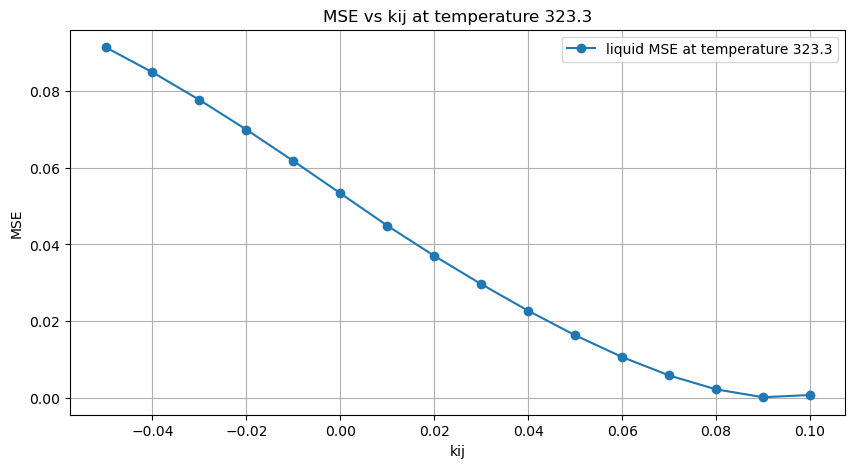

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

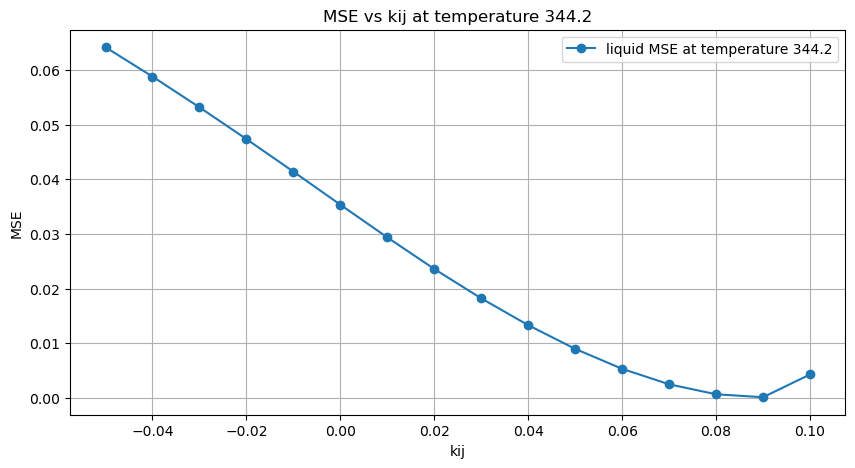

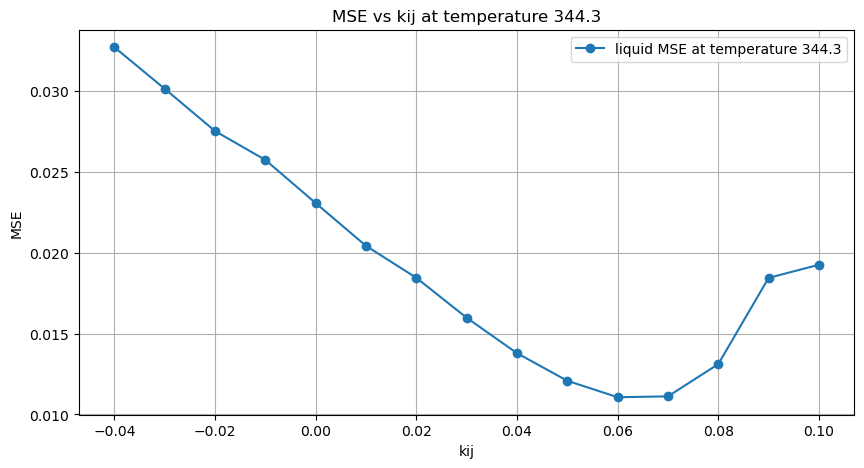

<Figure size 1000x500 with 0 Axes>

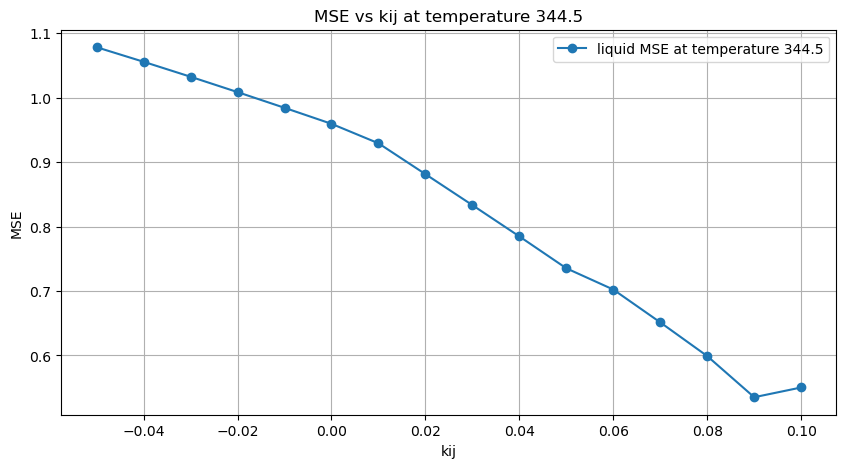

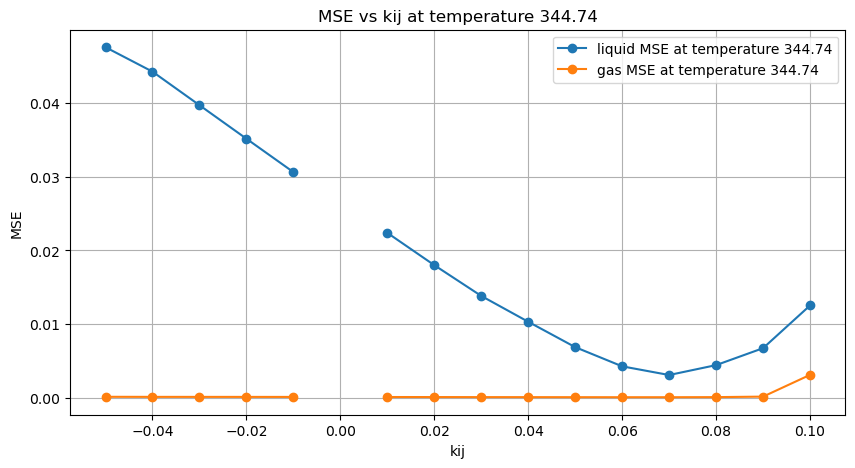

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

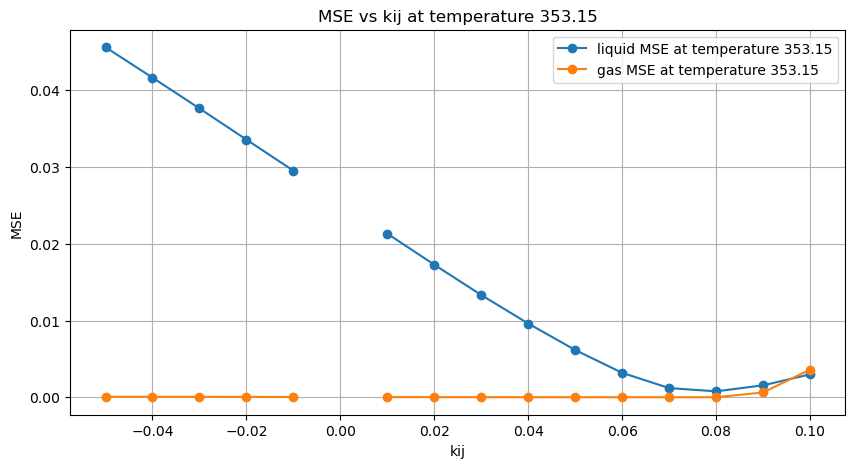

<Figure size 1000x500 with 0 Axes>

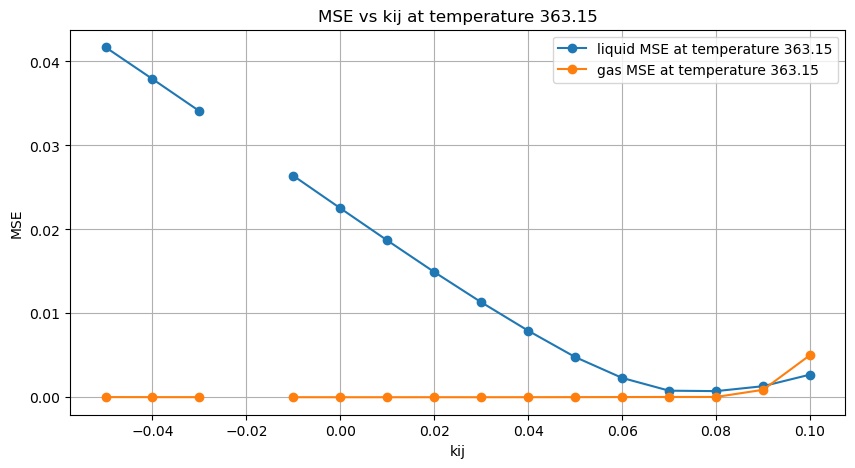

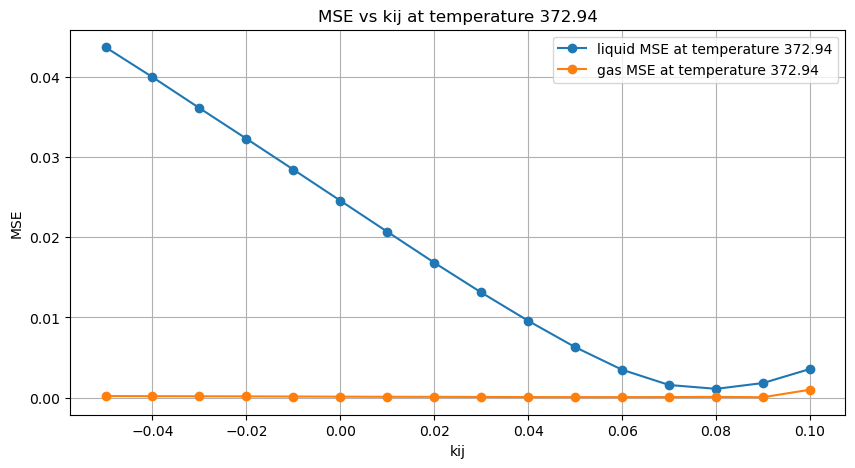

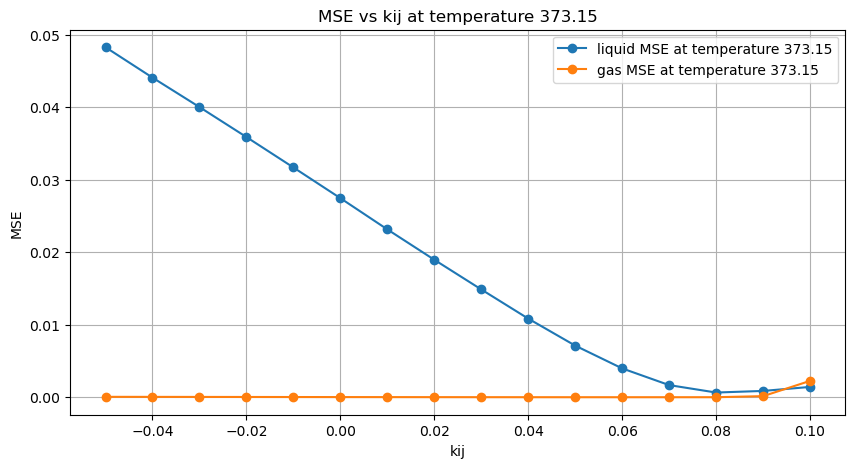

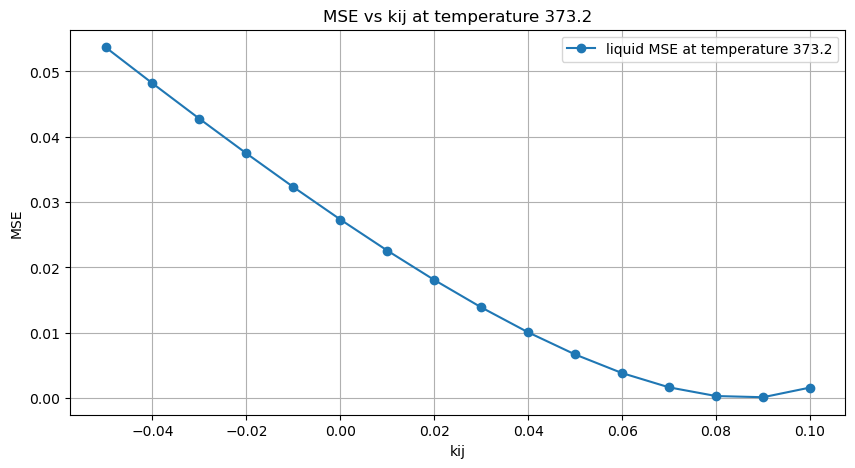

In [34]:
import matplotlib.pyplot as plt
import numpy as np

def plot_mse_t(data):
    for kij, temp_dict in sorted(data.items()):
        temperatures = []
        mse_values = []
        
        for temperature, mse in sorted(temp_dict.items()):
            if mse is not None:
                temperatures.append(temperature)
                mse_values.append(mse)
        
        if temperatures:
            plt.figure(figsize=(10, 5))

            plot_values_gas = [mv[0] for mv in mse_values]
            plot_values_liquid = [mv[1] for mv in mse_values]
            is_gas = any(elem is not None for elem in plot_values_gas)
            is_liquid = any(elem is not None for elem in plot_values_liquid)
            
            if is_liquid:
                plt.plot(temperatures, plot_values_liquid, label=f'liquid MSE at temperature {kij}', marker='o')

            if is_gas:
                plt.plot(temperatures, plot_values_gas, label=f'gas MSE at temperature {kij}', marker='o')

            if not (is_gas or is_liquid): continue
                
            plt.title(f'MSE vs kij at temperature {kij}')
            plt.xlabel('kij')
            plt.ylabel('MSE')
            # plt.xscale('log')
            # plt.yscale('log')  # Use logarithmic scale for y-axis as well if needed
            plt.legend()
            plt.grid(True)
            
            plt.show()

plot_mse_t(mses)